In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import timedelta
import xarray as xr
from glob import glob
import itertools
import sys, os
import cartopy
cartopy.config['pre_existing_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['repo_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])
pr1=ccrs.PlateCarree()

sys.path.insert(0, os.path.abspath(os.path.join("/home1/datahome/abouras/VirtualCrocoFleet")))
from virtualargofleet import Velocity, VirtualFleet, FloatConfiguration, VelocityField

import parcels
parcels.__version__

'3.1.0'

In [2]:
files = glob('/scale/project/shom_simurep/public_no_ftp/PROJETS/IberArgo/Data/GIGATL/NEW_DOMAIN_WITH_DEPTHS/*.nc')
files.sort()
#print(files)
files=files[79:171]
print(files[0],'\n to \n',files[-1])
ds = xr.open_dataset(files[0])

/scale/project/shom_simurep/public_no_ftp/PROJETS/IberArgo/Data/GIGATL/NEW_DOMAIN_WITH_DEPTHS/gigatl1_1h_tides_iberia2_daily_2008-06-01.nc 
 to 
 /scale/project/shom_simurep/public_no_ftp/PROJETS/IberArgo/Data/GIGATL/NEW_DOMAIN_WITH_DEPTHS/gigatl1_1h_tides_iberia2_daily_2008-08-31.nc


In [3]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:     (y_rho: 1400, x_rho: 1155, y_v: 1400, x_u: 1155, one: 1,
                 time: 1, sig_rho: 100)
Coordinates:
    lon_rho     (y_rho, x_rho) float64 13MB ...
    lat_rho     (y_rho, x_rho) float64 13MB ...
    lon_psi     (y_v, x_u) float64 13MB ...
    lat_psi     (y_v, x_u) float64 13MB ...
    lon_u       (y_rho, x_u) float64 13MB ...
    lat_u       (y_rho, x_u) float64 13MB ...
    lon_v       (y_v, x_rho) float64 13MB ...
    lat_v       (y_v, x_rho) float64 13MB ...
  * time        (time) datetime64[ns] 8B 2008-06-01
Dimensions without coordinates: y_rho, x_rho, y_v, x_u, one, sig_rho
Data variables: (12/15)
    angle       (y_rho, x_rho) float64 13MB ...
    corio       (y_rho, x_rho) float64 13MB ...
    ex          (y_rho, x_rho) float64 13MB ...
    ey          (y_rho, x_rho) float64 13MB ...
    mask_rho    (y_rho, x_rho) float64 13MB ...
    xl          (one) float64 8B ...
    ...          ...
    sal         (time, sig_rho, y_rho, x_rho) float32 647MB ...
    u           (time, sig_rho, y_rho, x_u) float32 647MB ...
    v           (time, sig_rho, y_v, x_rho) float32 647MB ...
    ocean_time  (time) float32 4B ...
    bathy       (y_rho, x_rho) float64 13MB ...
    depth_rho   (time, sig_rho, y_rho, x_rho) float32 647MB ...

In [4]:
variables = {'U': 'u', 'V': 'v', 'depth_rho':'depth_rho'}

dimensions = {'U': {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'not_yet_set', 'time': 'time'},
              'V': {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'not_yet_set', 'time': 'time'},
              'depth_rho' : {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'not_yet_set', 'time': 'time'}              
             }

fieldset = FieldSet.from_c_grid_dataset(files,variables,dimensions,allow_time_extrapolation=True)

In [5]:
fieldset.U.set_depth_from_field(fieldset.depth_rho)
fieldset.V.set_depth_from_field(fieldset.depth_rho)

In [6]:
# I prefer add the bathy like that, then I'm sure that the bathy value is when there's no data (I'm not sure of that with the bathy var in the gigatl file)
df = xr.open_dataset(files[0]) 
mask = df.isel(time=0)['depth_rho'].max(['sig_rho']) - 50
fieldset.add_field(Field('bathy',mask.values,lon=fieldset.U.lon,lat=fieldset.U.lat,interp_method='nearest'))

In [7]:
fieldset.computeTimeChunk(fieldset.U.grid.time[0], 1.)

86400.0

/home1/datahome/kbalem/conda-env/xarray2024K/lib/python3.10/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/home1/datahome/kbalem/conda-env/xarray2024K/lib/python3.10/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/home1/datahome/kbalem/conda-env/xarray2024K/lib/python3.10/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/home1/datahome/kbalem/conda-env/xarray2024K/lib/python3.10/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/home1/datahome/kbalem/conda-env/xarray2024K/lib/python3.10/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/home1/datahome/kbalem/conda-env/xarray2024K/lib/python3.10/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


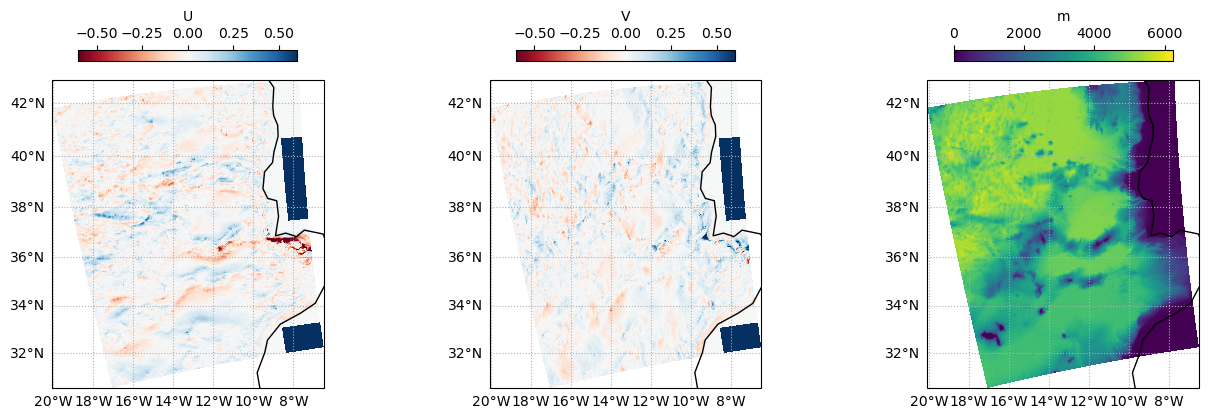

In [8]:
fig=plt.figure(figsize=(16,5))
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 3, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.U.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=-0.6,vmax=0.6,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
plt.colorbar(a,location='top',shrink=0.6,label='U')
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1 = fig.add_subplot(1, 3, 2, projection=pr2)
a=ax1.pcolormesh(fieldset.V.grid.lon,fieldset.V.grid.lat,fieldset.V.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=-0.6,vmax=0.6,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
plt.colorbar(a,location='top',shrink=0.6,label='V')
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1 = fig.add_subplot(1, 3, 3, projection=pr2)
a=ax1.pcolormesh(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:-1,:-1],shading='flat',transform=pr1,cmap=plt.get_cmap('viridis'),vmin=0)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
plt.colorbar(a,location='top',shrink=0.6,label='m')

In [9]:
# Check if we can interpolate ?
print(fieldset.UV[0,10,40.5,-14],fieldset.bathy[0,10,40.5,-14])

(-5.76900589655465e-07, 1.1265466247177072e-06) 3761.804


In [10]:
min_depth = 2.5 #np.ceil(ds['depth_rho'].max(['sig_rho']).min().values)
max_depth = int(fieldset.gridset.grids[0].depth.max() / 100)*100
print(min_depth,max_depth)

2.5 6200


In [11]:
fieldset.add_constant("vf_surface",min_depth)
fieldset.add_constant("vf_bottom", max_depth)

In [13]:
fbox = [-17,31,-16,32]
coords=np.array(list(itertools.product(np.arange(fbox[0],fbox[2],.25),np.arange(fbox[1],fbox[3],.25))))
lon = coords[:,0]
lat = coords[:,1]
nfloats=len(lon)
tim = np.array(['2008-06-01T12:00:00.00' for i in range(nfloats)],dtype='datetime64')
depth = np.array([min_depth for i in range(nfloats)])
# Define the deployment plan as a dictionary:
my_plan = {'lat': lat, 
           'lon': lon, 
           'time': tim, 
           'depth':depth}
print(nfloats)

16


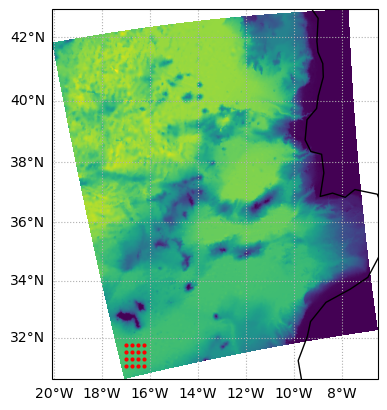

In [14]:
fig=plt.figure()
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 1, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:-1,:-1],shading='flat',transform=pr1,cmap=plt.get_cmap('viridis'),vmin=0)
#b=ax1.contourf(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:,:],np.arange(990,1010),transform=pr1)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1.plot(my_plan['lon'],my_plan['lat'],'r.',markersize=4,transform=pr1)

In [15]:
cfg = FloatConfiguration('default')
cfg.update('cycle_duration',24*10)
cfg.update('profile_depth',2000)
cfg.update('parking_depth',1000)
cfg

<FloatConfiguration><default>
- cycle_duration (Maximum length of float complete cycle): 240.0 [hours]
- life_expectancy (Maximum number of completed cycle): 200 [cycle]
- parking_depth (Drifting depth): 1000.0 [m]
- profile_depth (Maximum profile depth): 2000.0 [m]
- vertical_speed (Vertical profiling speed): 0.09 [m/s]

In [17]:
VFleet = VirtualFleet(plan=my_plan, fieldset=fieldset, mission=cfg, verbose_events=1)
VFleet

<VirtualFleet>
- 16 floats in the deployment plan
- No simulation performed

In [ ]:
VFleet.simulate(
    duration=timedelta(days=91),
    step=timedelta(minutes=5),
    record=timedelta(minutes=60),
    output_folder="/home1/scratch/kbalem/",
)

/home1/datahome/kbalem/VirtualCrocoFleet/virtualargofleet/virtualargofleet.py:332: UserWarning: Simulation will be saved in : /home1/scratch/kbalem/8j9eibcz.zarr
  warnings.warn(output_msg)


INFO: Output files are stored in /home1/scratch/kbalem/8j9eibcz.zarr.
 10%|█         | 821100.0/7862400.0 [13:34<4:00:31, 487.90it/s] Phase 0 warning: Overshoot drift_depth, re-adjust depth to target
Phase 0 warning: Overshoot drift_depth, re-adjust depth to target
Phase 0 warning: Overshoot drift_depth, re-adjust depth to target
Phase 0 warning: Overshoot drift_depth, re-adjust depth to target
Phase 0 warning: Overshoot drift_depth, re-adjust depth to target
Phase 0 warning: Overshoot drift_depth, re-adjust depth to target
Phase 0 warning: Overshoot drift_depth, re-adjust depth to target
Phase 0 warning: Overshoot drift_depth, re-adjust depth to target
Phase 0 warning: Overshoot drift_depth, re-adjust depth to target
Phase 0 warning: Overshoot drift_depth, re-adjust depth to target
Phase 0 warning: Overshoot drift_depth, re-adjust depth to target
Phase 0 warning: Overshoot drift_depth, re-adjust depth to target
Phase 0 warning: Overshoot drift_depth, re-adjust depth to target
Phase 0 